In [1]:
#import modules
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import h5py
import tensorflow.compat.v1 as tf
import tensorflow as tf2

from DlModels import DlModels
from TrainDL import TrainDL
from DataLoader import DataLoader

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
tf.config.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.backend.set_floatx('float32') #for memory use

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


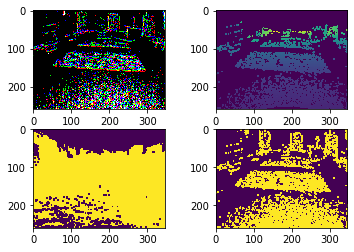

In [4]:
#test batching
data_loader = DataLoader('indoor_flying_preprocessed.hdf5')

event_images, depth_images, mask_1, mask_2 = data_loader.load_all()

fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.imshow(np.array(event_images[10][:,:,0:3]))
ax.autoscale(True)
ax2 = fig.add_subplot(2, 2, 2, sharex=ax, sharey=ax)
ax2.imshow(np.array(depth_images[10]))
ax2.autoscale(True)
ax3 = fig.add_subplot(2, 2, 3, sharex=ax, sharey=ax)
ax3.imshow(np.array(mask_1[10]))
ax3.autoscale(True)
ax4 = fig.add_subplot(2, 2, 4, sharex=ax, sharey=ax)
ax4.imshow(np.array(mask_2[10]))
ax4.autoscale(True)
plt.show()


In [5]:
epochs = 30
batch_size = 8
base_learning_rate = 0.001
learning_decay_rate = 10
learning_decay_factor = 0.5
data_loader = DataLoader('indoor_flying_preprocessed.hdf5')

tf.compat.v1.disable_eager_execution()
input_image = tf.placeholder(tf.float32, [None, None, None, 9], name='input_image')
depth_image = tf.placeholder(tf.float32, [None, None, None, 1], name='depth_image')
mask_image_1 = tf.placeholder(tf.float32, [None, None, None, 1], name='mask_image_1')
mask_image_2 = tf.placeholder(tf.float32, [None, None, None, 1], name='mask_image_2')
learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

sess = tf.Session()

# Build NN using load_vgg, layers, and optimize function
nn_last_layer = DlModels.vggDecoder(input_image, DlModels.vgg11)

train_op, loss = TrainDL.MSEOptimize(nn_last_layer, depth_image, mask_image_1, mask_image_2, learning_rate)

# Train NN using the train_nn function
TrainDL.train_nn(sess, epochs, batch_size, data_loader, train_op, loss, input_image, depth_image, mask_image_1, mask_image_2, learning_rate, base_learning_rate, learning_decay_rate, learning_decay_factor)
        
# save trained model
saver = tf.train.Saver()
saver.save(sess, './model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Training...

EPOCH 1 ...
Loss: =
1946137156.9014184

EPOCH 2 ...
Loss: =
951295986.7936817

EPOCH 3 ...
Loss: =
657235906.538818

EPOCH 4 ...
Loss: =
719252371.356582

EPOCH 5 ...
Loss: =
443049892.75641936

EPOCH 6 ...
Loss: =
430078754.1441259

EPOCH 7 ...
Loss: =
396147663.97844607

EPOCH 8 ...
Loss: =
341293661.8666923

EPOCH 9 ...
Loss: =
299793376.41058916

EPOCH 10 ...
Loss: =
308678012.1917649

EPOCH 11 ...
Loss: =
321698843.95115644

EPOCH 12 ...
Loss: =
339566255.7237078

EPOCH 13 ...
Loss: =
318064816.3853143

EPOCH 14 ...
Loss: =
287012885.27964634

EPOCH 15 ...
Loss: =
263054324.08837768

EPOCH 16 ...
Loss: =
259559286.9901122

EPOCH 17 ...
Loss: =
209822490.7470861

EPOCH 18 ...
Loss: =
203603946.857211

EPOCH 19 ...
Loss: =
243210597.87344822

EPOCH 20 ...
Loss: =
224410711.01119995

EPOCH 21 ...
Loss: =
275735402.27612036

EPOCH 22 ...
Loss: =
237835614.18378457

EPOCH 23 ...
Loss: =
188013

'./model'

In [12]:
sample_image = event_images[70]
est_depth = sess.run([nn_last_layer], feed_dict={input_image: sample_image.reshape(1, np.shape(sample_image)[0], :, 9)})

#plt.imshow(est_depth[0].reshape(target_height, target_width))
plt.imshow(np.multiply(mask_2[70],  est_depth[0]))

SyntaxError: invalid syntax (<ipython-input-12-d21928fecdbf>, line 2)

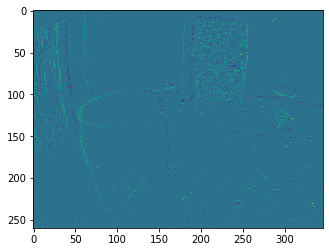

In [7]:
plt.imshow(sample_image[:,:,0])

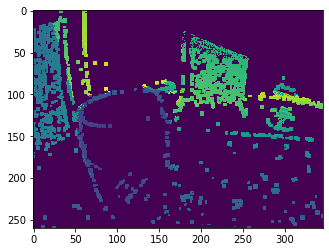

In [8]:
plt.imshow(depth_images[70])